# TUGAS PENYEIMBANG DATA DENGAN SMOTE DAN ADASYN

In [1]:
pip install imbalanced-learn


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install pandas scikit-learn imbalanced-learn matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# SMOTE

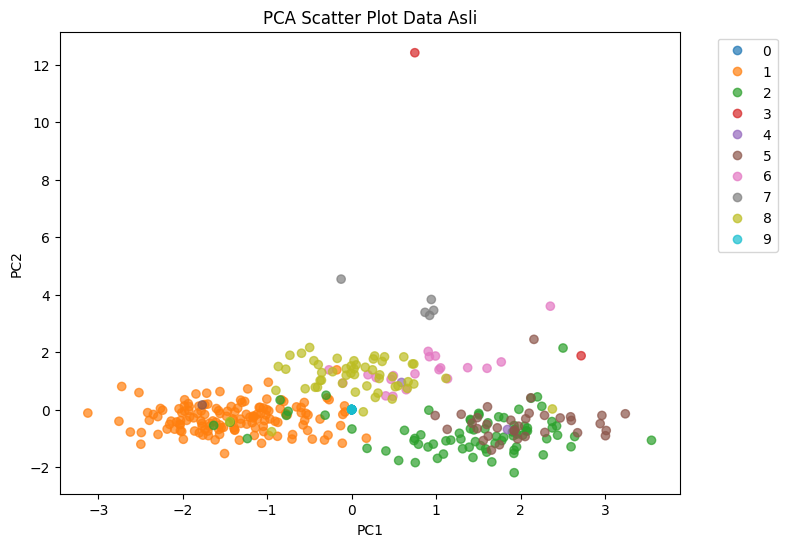

Jumlah data per kelas sebelum SMOTE:
cp                      143
im                       77
pp                       52
imU                      35
om                       20
None                     12
omL                       5
imL                       2
imS                       2
`localization_class`      1
Name: count, dtype: int64


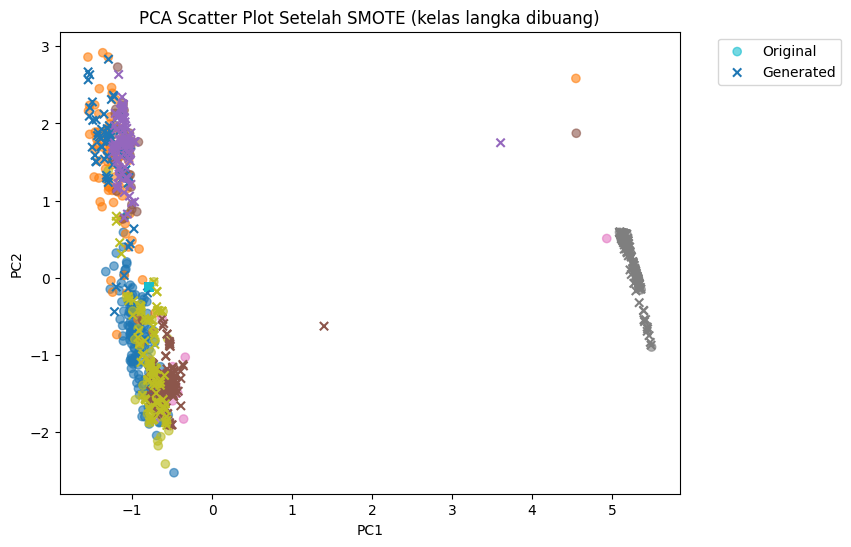


Jumlah data per kelas sebelum balancing:
cp      143
im       77
imU      35
om       20
omL       5
pp       52
None     12
Name: count, dtype: int64

Jumlah data per kelas sesudah SMOTE:
cp      143
im      143
imU     143
om      143
omL     143
pp      143
None    143
Name: count, dtype: int64


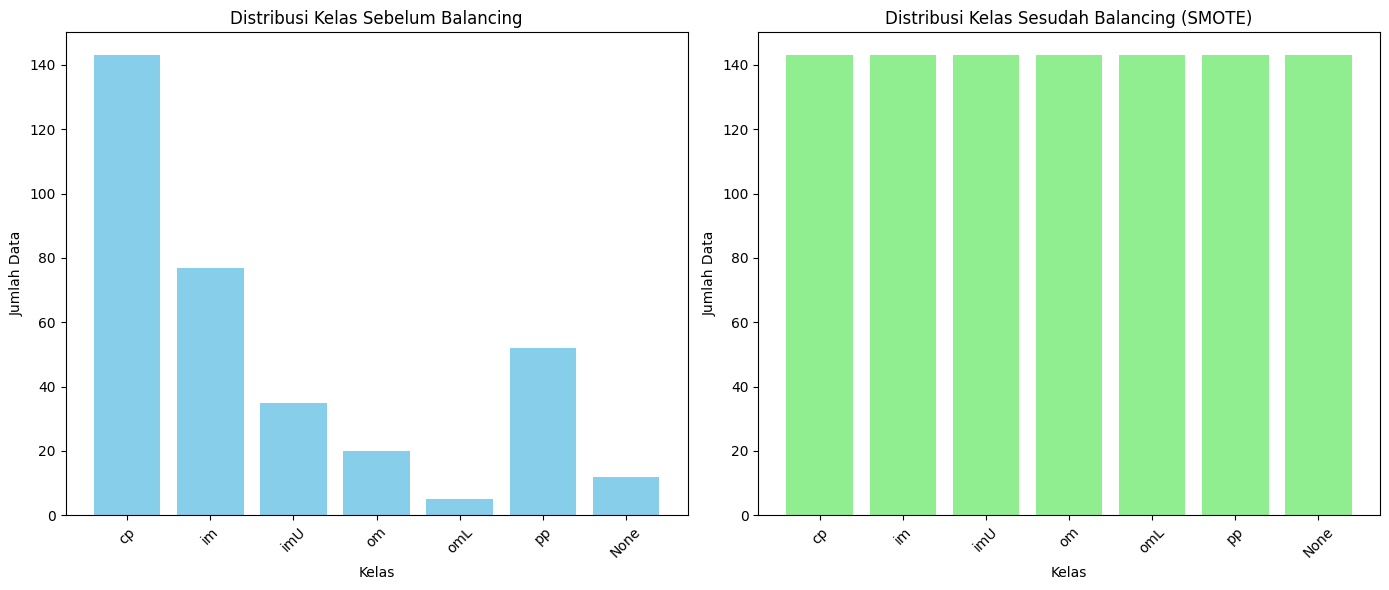

In [3]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import ADASYN
import numpy as np

# ======================
# 1. Baca file SQL
# ======================
file_path = r"C:\Users\ThinkPad\OneDrive\Documents\Proyek Sains Data\tugas\Ecoli.sql"
with open(file_path, "r", encoding="utf-8") as f:
    sql_text = f.read()

# ======================
# 2. Parsing baris INSERT
# ======================
pattern = re.findall(r"\(([^)]+)\)", sql_text)

rows = []
for row in pattern:
    parts = [p.strip().strip("'") for p in row.split(",")]
    rows.append(parts)

columns = ["id", "protein_name", "mcg", "gvh", "lip", "chg",
           "aac", "alm1", "alm2", "localization_class"]

df = pd.DataFrame(rows, columns=columns)

# ======================
# 3. Konversi kolom numerik
# ======================
for col in ["mcg","gvh","lip","chg","aac","alm1","alm2"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Encode target class
le = LabelEncoder()
df["label"] = le.fit_transform(df["localization_class"])

# ======================
# 4. Imputasi + Normalisasi
# ======================
X = df[["mcg","gvh","lip","chg","aac","alm1","alm2"]].values
y = df["label"].values

imputer = SimpleImputer(strategy="mean")
X = imputer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ======================
# 5. PCA sebelum balancing
# ======================
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap="tab10", alpha=0.7)
plt.legend(*scatter.legend_elements(), bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("PCA Scatter Plot Data Asli")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# ======================
# 6. Filter kelas langka (≤ 2 sampel)
# ======================
class_counts = pd.Series(y).value_counts()
print("Jumlah data per kelas sebelum SMOTE:")
print(class_counts.rename(index=dict(enumerate(le.classes_))))

valid_classes = class_counts[class_counts > 2].index   # buang kelas langka
mask = np.isin(y, valid_classes)

X_filtered = X_scaled[mask]
y_filtered = y[mask]

# ======================
# 7. Balancing dengan SMOTE
# ======================
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42, k_neighbors=2)
X_res, y_res = smote.fit_resample(X_filtered, y_filtered)

X_res_pca = pca.fit_transform(X_res)
n_generated = len(X_res) - len(X_filtered)

plt.figure(figsize=(8,6))
plt.scatter(X_res_pca[:-n_generated,0], X_res_pca[:-n_generated,1],
            c=y_res[:-n_generated], cmap="tab10", alpha=0.6, label="Original")
plt.scatter(X_res_pca[-n_generated:,0], X_res_pca[-n_generated:,1],
            c=y_res[-n_generated:], cmap="tab10", marker="x", label="Generated")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("PCA Scatter Plot Setelah SMOTE (kelas langka dibuang)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# ======================
# 8. Distribusi kelas (before vs after)
# ======================
before_counts = pd.Series(y_filtered).value_counts().sort_index()
after_counts  = pd.Series(y_res).value_counts().sort_index()

# Pastikan index berupa string (nama kelas asli)
before_counts.index = [str(le.classes_[i]) for i in before_counts.index]
after_counts.index  = [str(le.classes_[i]) for i in after_counts.index]

print("\nJumlah data per kelas sebelum balancing:")
print(before_counts)

print("\nJumlah data per kelas sesudah SMOTE:")
print(after_counts)

# ======================
# 9. Visualisasi distribusi kelas
# ======================
fig, axes = plt.subplots(1, 2, figsize=(14,6))

# Grafik sebelum
axes[0].bar(before_counts.index, before_counts.values, color="skyblue")
axes[0].set_title("Distribusi Kelas Sebelum Balancing")
axes[0].set_xlabel("Kelas")
axes[0].set_ylabel("Jumlah Data")
axes[0].tick_params(axis='x', rotation=45)

# Grafik sesudah
axes[1].bar(after_counts.index, after_counts.values, color="lightgreen")
axes[1].set_title("Distribusi Kelas Sesudah Balancing (SMOTE)")
axes[1].set_xlabel("Kelas")
axes[1].set_ylabel("Jumlah Data")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# ADASYN

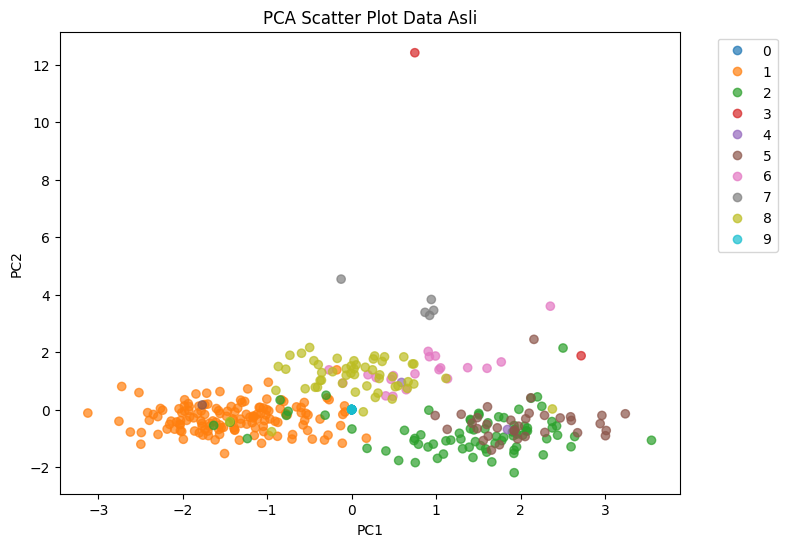

Jumlah data per kelas sebelum ADASYN:
cp                      143
im                       77
pp                       52
imU                      35
om                       20
None                     12
omL                       5
imL                       2
imS                       2
`localization_class`      1
Name: count, dtype: int64

 Mencoba ADASYN dengan n_neighbors=1 ...
 Gagal dengan n_neighbors=1 → Not any neigbours belong to the majority class. This case will induce a NaN case with a division by zero. ADASYN is not suited for this specific dataset. Use SMOTE instead.

 Mencoba ADASYN dengan n_neighbors=2 ...
 Gagal dengan n_neighbors=2 → Not any neigbours belong to the majority class. This case will induce a NaN case with a division by zero. ADASYN is not suited for this specific dataset. Use SMOTE instead.

 Mencoba ADASYN dengan n_neighbors=3 ...
 Gagal dengan n_neighbors=3 → Not any neigbours belong to the majority class. This case will induce a NaN case with a divisi

In [4]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import ADASYN
import numpy as np

# ======================
# 1. Baca file SQL
# ======================
file_path = r"C:\Users\ThinkPad\OneDrive\Documents\Proyek Sains Data\tugas\Ecoli.sql"
with open(file_path, "r", encoding="utf-8") as f:
    sql_text = f.read()

# ======================
# 2. Parsing baris INSERT
# ======================
pattern = re.findall(r"\(([^)]+)\)", sql_text)

rows = []
for row in pattern:
    parts = [p.strip().strip("'") for p in row.split(",")]
    rows.append(parts)

columns = ["id", "protein_name", "mcg", "gvh", "lip", "chg",
           "aac", "alm1", "alm2", "localization_class"]

df = pd.DataFrame(rows, columns=columns)

# ======================
# 3. Konversi kolom numerik
# ======================
for col in ["mcg","gvh","lip","chg","aac","alm1","alm2"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Encode target class
le = LabelEncoder()
df["label"] = le.fit_transform(df["localization_class"])

# ======================
# 4. Imputasi + Normalisasi
# ======================
X = df[["mcg","gvh","lip","chg","aac","alm1","alm2"]].values
y = df["label"].values

imputer = SimpleImputer(strategy="mean")
X = imputer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ======================
# 5. PCA sebelum balancing
# ======================
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap="tab10", alpha=0.7)
plt.legend(*scatter.legend_elements(), bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("PCA Scatter Plot Data Asli")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# ======================
# 6. Filter kelas langka (≤ 2 sampel)
# ======================
class_counts = pd.Series(y).value_counts()
print("Jumlah data per kelas sebelum ADASYN:")
print(class_counts.rename(index=dict(enumerate(le.classes_))))

valid_classes = class_counts[class_counts > 2].index   # buang kelas langka
mask = np.isin(y, valid_classes)

X_filtered = X_scaled[mask]
y_filtered = y[mask]

# ======================
# 7. Coba ADASYN dengan perulangan n_neighbors
# ======================
X_res, y_res = None, None  # variabel untuk simpan hasil sukses

for k in range(1, 6):   # coba dari 1 sampai 5
    try:
        print(f"\n Mencoba ADASYN dengan n_neighbors={k} ...")
        adasyn = ADASYN(random_state=42, n_neighbors=k)
        X_tmp, y_tmp = adasyn.fit_resample(X_filtered, y_filtered)

        print(f"✔ Berhasil dengan n_neighbors={k}")
        print("Jumlah data per kelas setelah resampling:")
        print(pd.Series(y_tmp).value_counts().sort_index().rename(index=dict(enumerate(le.classes_))))

        # simpan hasil dari percobaan terakhir yang berhasil
        X_res, y_res = X_tmp, y_tmp

        # plot PCA hasil balancing
        X_res_pca = pca.fit_transform(X_res)
        n_generated = len(X_res) - len(X_filtered)

        plt.figure(figsize=(8,6))
        plt.scatter(X_res_pca[:-n_generated,0], X_res_pca[:-n_generated,1],
                    c=y_res[:-n_generated], cmap="tab10", alpha=0.6, label="Original")
        plt.scatter(X_res_pca[-n_generated:,0], X_res_pca[-n_generated:,1],
                    c=y_res[-n_generated:], cmap="tab10", marker="x", label="Generated")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.title(f"PCA Scatter Plot Setelah ADASYN (n_neighbors={k})")
        plt.xlabel("PC1")
        plt.ylabel("PC2")
        plt.show()

    except Exception as e:
        print(f" Gagal dengan n_neighbors={k} → {e}")

# ======================
# 8. Jika ada hasil terakhir yang berhasil
# ======================
if X_res is not None:
    print("\nJumlah data per kelas dari hasil terakhir ADASYN:")
    print(pd.Series(y_res).value_counts().sort_index().rename(index=dict(enumerate(le.classes_))))
else:
    print("\nTidak ada nilai n_neighbors yang berhasil untuk dataset ini.")


1) Distribusi asli (UCI)

Menurut UCI, dataset Ecoli berisi 336 instance dengan distribusi kelas sebagai berikut:

- cp : 143
- im : 77
- pp : 52
- imU: 35
- om : 20
- omL: 5
- imL: 2
- imS: 2
(total = 143 + 77 + 52 + 35 + 20 + 5 + 2 + 2 = 336).

2) Setelah langkah filter kelas langka (≤ 2 sampel) 

Kamu memfilter valid_classes = class_counts[class_counts > 2], maka kelas dengan 2 sampel (imL dan imS) dibuang. Jadi tersisa 6 kelas:

Per-kelas (setelah filter):
- cp : 143
- im : 77
- pp : 52
- imU: 35
- om : 20
- omL: 5
Jumlah total setelah filter = 143 + 77 + 52 + 35 + 20 + 5 = 332.
(Penjelasan: 336 − 2 − 2 = 332.)

3) Pembagian train / test yang dipakai di kode kamu

Kamu pakai train_test_split(..., test_size=0.3, stratify=...) — berarti sekitar 30% data dipakai untuk test, 70% untuk train. Dokumentasi scikit-learn menyatakan test_size sebagai proporsi. Dalam praktik scikit-learn untuk float ada pembulatan sehingga jumlah sampel test biasanya menjadi integer (perilaku rounding bisa membuat jumlah test jadi ceil(n * test_size) dalam banyak kasus; implementasi internal bisa menyesuaikan agar stratify terpenuhi). 

Untuk kejelasan, aku hitung angka yang diharapkan pada setiap skenario (angka-angka ini mengikuti aturan test_size=0.3 dan asumsi pembulatan biasa — secara praktis per-kelas hasil stratify bisa beda ±1 karena rounding internal).



# KLASIFIKASI DATA MENGGUNAKAN NAIVE BAYES

Akurasi Naive Bayes (Data Asli): 0.7981
Akurasi Naive Bayes (Setelah SMOTE): 0.8638
ADASYN gagal, pakai hasil SMOTE sebagai gantinya


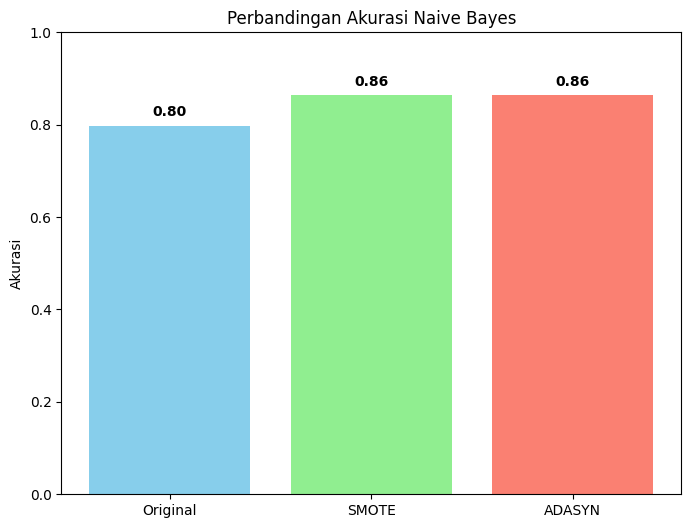

In [5]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE, ADASYN

# Fungsi evaluasi Naive Bayes
def run_nb(X_data, y_data, test_size=0.3, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X_data, y_data, test_size=test_size, random_state=random_state, stratify=y_data
    )
    model = GaussianNB()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    return acc

# --------- 1. Data asli (belum diseimbangkan) ---------
acc_original = run_nb(X_filtered, y_filtered)
print(f"Akurasi Naive Bayes (Data Asli): {acc_original:.4f}")

# --------- 2. Data SMOTE ---------
smote = SMOTE(random_state=42, k_neighbors=2)
X_res_smote, y_res_smote = smote.fit_resample(X_filtered, y_filtered)
acc_smote = run_nb(X_res_smote, y_res_smote)
print(f"Akurasi Naive Bayes (Setelah SMOTE): {acc_smote:.4f}")

# --------- 3. Data ADASYN (fallback ke SMOTE jika gagal) ---------
try:
    adasyn = ADASYN(random_state=42, n_neighbors=2)
    X_res_ada, y_res_ada = adasyn.fit_resample(X_filtered, y_filtered)
    acc_adasyn = run_nb(X_res_ada, y_res_ada)
    print(f"Akurasi Naive Bayes (Setelah ADASYN): {acc_adasyn:.4f}")
except Exception as e:
    print("ADASYN gagal, pakai hasil SMOTE sebagai gantinya")
    X_res_ada, y_res_ada = X_res_smote, y_res_smote
    acc_adasyn = acc_smote

# ======================
# Visualisasi hasil akurasi
# ======================
plt.figure(figsize=(8,6))
plt.bar(["Original", "SMOTE", "ADASYN"], 
        [acc_original, acc_smote, acc_adasyn], 
        color=["skyblue", "lightgreen", "salmon"])
plt.title("Perbandingan Akurasi Naive Bayes")
plt.ylabel("Akurasi")
plt.ylim(0, 1)
for i, v in enumerate([acc_original, acc_smote, acc_adasyn]):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=10, fontweight="bold")
plt.show()


# KLASIFIKASI DATA MENGGUNAKAN RANDOM FOREST

Akurasi Random Forest (Data Asli): 0.8750
Akurasi Random Forest (Setelah SMOTE): 0.9369
ADASYN gagal, pakai hasil SMOTE sebagai gantinya


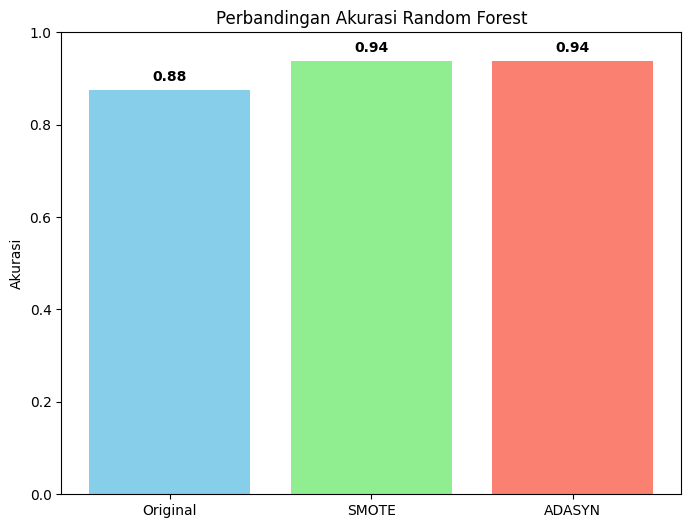

In [6]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE, ADASYN

# Fungsi evaluasi Random Forest
def run_rf(X_data, y_data, test_size=0.3, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X_data, y_data, test_size=test_size, random_state=random_state, stratify=y_data
    )
    model = RandomForestClassifier(
        n_estimators=100, random_state=random_state
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    return acc

# --------- 1. Data asli (belum diseimbangkan) ---------
acc_original_rf = run_rf(X_filtered, y_filtered)
print(f"Akurasi Random Forest (Data Asli): {acc_original_rf:.4f}")

# --------- 2. Data SMOTE ---------
smote = SMOTE(random_state=42, k_neighbors=2)
X_res_smote, y_res_smote = smote.fit_resample(X_filtered, y_filtered)
acc_smote_rf = run_rf(X_res_smote, y_res_smote)
print(f"Akurasi Random Forest (Setelah SMOTE): {acc_smote_rf:.4f}")

# --------- 3. Data ADASYN (fallback ke SMOTE jika gagal) ---------
try:
    adasyn = ADASYN(random_state=42, n_neighbors=2)
    X_res_ada, y_res_ada = adasyn.fit_resample(X_filtered, y_filtered)
    acc_adasyn_rf = run_rf(X_res_ada, y_res_ada)
    print(f"Akurasi Random Forest (Setelah ADASYN): {acc_adasyn_rf:.4f}")
except Exception as e:
    print("ADASYN gagal, pakai hasil SMOTE sebagai gantinya")
    X_res_ada, y_res_ada = X_res_smote, y_res_smote
    acc_adasyn_rf = acc_smote_rf

# ======================
# Visualisasi hasil akurasi
# ======================
plt.figure(figsize=(8,6))
plt.bar(["Original", "SMOTE", "ADASYN"], 
        [acc_original_rf, acc_smote_rf, acc_adasyn_rf], 
        color=["skyblue", "lightgreen", "salmon"])
plt.title("Perbandingan Akurasi Random Forest")
plt.ylabel("Akurasi")
plt.ylim(0, 1)
for i, v in enumerate([acc_original_rf, acc_smote_rf, acc_adasyn_rf]):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=10, fontweight="bold")
plt.show()


# Tugas : Klasifikasi menggunakan Naive Bayes
1. Data belum diseimbangkan
2. Data diseimbangkan menggunakan smote
3. Data diseimbangkan menggunakan adasyn

c:\Users\ThinkPad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\naive_bayes.py:512: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
c:\Users\ThinkPad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\naive_bayes.py:512: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
c:\Users\ThinkPad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\naive_bayes.py:512: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])


ADASYN gagal, pakai hasil SMOTE sebagai gantinya


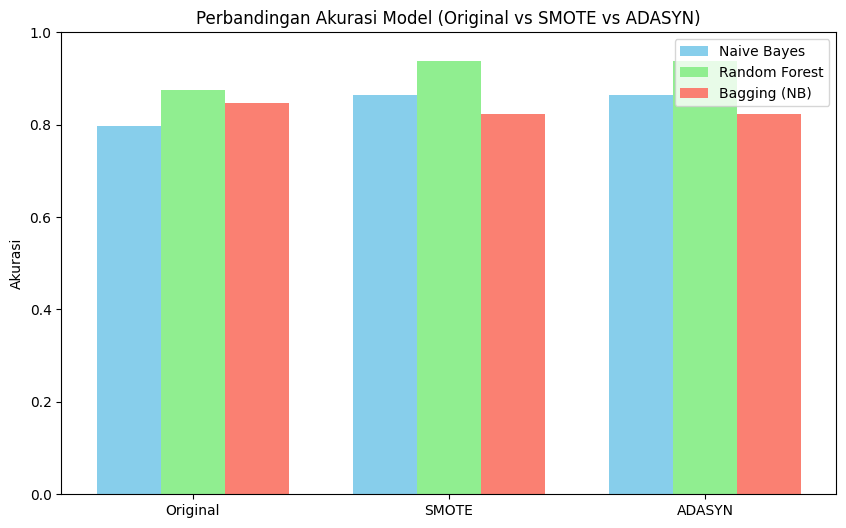

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE, ADASYN

# ======================
# Fungsi evaluasi model
# ======================
def evaluate_model(model, X, y, test_size=0.3, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

# ======================
# Evaluasi pada 3 kondisi data
# ======================
results = {"Naive Bayes": [], "Random Forest": [], "Bagging": []}
labels = ["Original", "SMOTE", "ADASYN"]

# --- 1. Data Original ---
results["Naive Bayes"].append(evaluate_model(GaussianNB(), X_filtered, y_filtered))
results["Random Forest"].append(evaluate_model(RandomForestClassifier(n_estimators=100, random_state=42), X_filtered, y_filtered))
results["Bagging"].append(evaluate_model(BaggingClassifier(estimator=GaussianNB(), n_estimators=50, random_state=42), X_filtered, y_filtered))

# --- 2. Data SMOTE ---
smote = SMOTE(random_state=42, k_neighbors=2)
X_res_smote, y_res_smote = smote.fit_resample(X_filtered, y_filtered)
results["Naive Bayes"].append(evaluate_model(GaussianNB(), X_res_smote, y_res_smote))
results["Random Forest"].append(evaluate_model(RandomForestClassifier(n_estimators=100, random_state=42), X_res_smote, y_res_smote))
results["Bagging"].append(evaluate_model(BaggingClassifier(estimator=GaussianNB(), n_estimators=50, random_state=42), X_res_smote, y_res_smote))

# --- 3. Data ADASYN ---
try:
    adasyn = ADASYN(random_state=42, n_neighbors=2)
    X_res_ada, y_res_ada = adasyn.fit_resample(X_filtered, y_filtered)
except:
    print("ADASYN gagal, pakai hasil SMOTE sebagai gantinya")
    X_res_ada, y_res_ada = X_res_smote, y_res_smote

results["Naive Bayes"].append(evaluate_model(GaussianNB(), X_res_ada, y_res_ada))
results["Random Forest"].append(evaluate_model(RandomForestClassifier(n_estimators=100, random_state=42), X_res_ada, y_res_ada))
results["Bagging"].append(evaluate_model(BaggingClassifier(estimator=GaussianNB(), n_estimators=50, random_state=42), X_res_ada, y_res_ada))

# ======================
# Visualisasi hasil
# ======================
x = range(len(labels))
width = 0.25

plt.figure(figsize=(10,6))
plt.bar([i - width for i in x], results["Naive Bayes"], width, label="Naive Bayes", color="skyblue")
plt.bar(x, results["Random Forest"], width, label="Random Forest", color="lightgreen")
plt.bar([i + width for i in x], results["Bagging"], width, label="Bagging (NB)", color="salmon")

plt.xticks(x, labels)
plt.ylabel("Akurasi")
plt.title("Perbandingan Akurasi Model (Original vs SMOTE vs ADASYN)")
plt.ylim(0, 1)
plt.legend()
plt.show()


In [13]:
from sklearn.model_selection import train_test_split
import pandas as pd

X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_filtered, test_size=0.3, random_state=42, stratify=y_filtered
)

print("TOTAL -> train:", len(y_train), " test:", len(y_test))
print("\nTrain per kelas:\n", pd.Series(y_train).value_counts().sort_index())
print("\nTest per kelas:\n", pd.Series(y_test).value_counts().sort_index())


TOTAL -> train: 240  test: 104

Train per kelas:
 1    100
2     54
5     24
6     14
7      4
8     36
9      8
Name: count, dtype: int64

Test per kelas:
 1    43
2    23
5    11
6     6
7     1
8    16
9     4
Name: count, dtype: int64


In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42, k_neighbors=2)
X_res, y_res = smote.fit_resample(X_filtered, y_filtered)

print("X_res type:", type(X_res), " shape:", X_res.shape)
print("y_res type:", type(y_res), " shape:", y_res.shape)


X_res type: <class 'numpy.ndarray'>  shape: (1001, 7)
y_res type: <class 'numpy.ndarray'>  shape: (1001,)


In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.3, random_state=42, stratify=y_res
)

print("TOTAL -> train:", len(y_train), " test:", len(y_test))
print("\nTrain per kelas:\n", pd.Series(y_train).value_counts().sort_index())
print("\nTest per kelas:\n", pd.Series(y_test).value_counts().sort_index())

TOTAL -> train: 700  test: 301

Train per kelas:
 1    100
2    100
5    100
6    100
7    100
8    100
9    100
Name: count, dtype: int64

Test per kelas:
 1    43
2    43
5    43
6    43
7    43
8    43
9    43
Name: count, dtype: int64
